# Setup

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import types, copy, pprint
import logging 
from datetime import datetime
if './src' not in sys.path:
    print(f"insert ./src")
    sys.path.insert(0, './src')
print(sys.path)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
import shutil
import getpass
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torchinfo import summary
print(torch.__version__)

pp = pprint.PrettyPrinter(indent=4)

pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# print("7- '%Y_%m_%d_%H:%M:%S'   : ",datetime.now().strftime('%Y%m%d_%H%M%S'))
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
print('Timestamp: ',timestamp)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

insert ./src
['./src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages']
2.2.1+cu118
Timestamp:  2024_05_01_16:44:24


In [3]:
# Soft Nearest Neighbor Loss
# Copyright (C) 2020  Abien Fred Agarap
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as published
# by the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.
#
# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
__author__ = "Abien Fred Agarap"
__version__ = "1.0.0"
"""Sample module for using DNN classifier with SNNL"""

# import argparse
# import torch
# from pt_datasets import create_dataloader, load_dataset
# from pt_datasets import display_cellpainting_batch
# from snnl.models import DNN
from snnl.utils import export_results, get_hyperparameters, set_global_seed, get_device, set_device
from snnl.utils import accuracy, load_model, save_model, import_results, export_results, save_checkpoint, load_checkpoint 
from snnl.utils import plot_model_parms, plot_train_history, display_epoch_metrics, display_model_history
from snnl.utils import plot_train_metrics, parse_args, display_cellpainting_batch
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn

from dev_base import Model
from dev_dnn import DNN 
from dev_autoencoder import Autoencoder
from dev_snnloss import SNNLoss

'Sample module for using DNN classifier with SNNL'

In [4]:
current_device = get_device()
print(f" Current device is : {current_device}")

 device: 0   Quadro GV100                   :  free: 22,659,268,608 B   (21.10 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 1   Quadro GV100                   :  free: 29,946,871,808 B   (27.89 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 2   NVIDIA TITAN Xp                :  free: 12,464,029,696 B   (11.61 GB)    total: 12,774,539,264 B   (11.90 GB)
 Current CUDA Device is: cuda:0 Quadro GV100 0
 Current device is : cuda:0


In [5]:
current_device = set_device(2)

 Running on: Quadro GV100 0
 Switch to cuda:2 
 Running on: NVIDIA TITAN Xp 2


### main(args)

In [6]:
# if __name__ == "__main__":
input_args = f" --seed              1234 " \
             f" --model             snnl" \
             f" --configuration       hyperparameters/dnn_cellpainting_classifier_03.json"
             # f" --configuration     hyperparameters/dnn_cellpainting_classifier_dropout.json"
             # f" --configuration     hyperparameters/dnn_cellpainting_classifier_02.json"
             # f" --configuration     hyperparameters/dnn_cellpainting_classifier_01.json"
             # f" --configuration     hyperparameters/dnn_cellpainting_unsupervised.json"
             # f" --configuration     hyperparameters/dnn_mnist.json"
             # f" --model             baseline" \
args = parse_args(input_args.split())
args
set_global_seed(args.seed)

# DNN
(   dataset,
    batch_size,
    epochs,
    learning_rate,
    units,
    activations,
    snnl_factor,
    temperature,
    cellpainting_args
 ) = get_hyperparameters(args.configuration)


Namespace(seed=1234, model='snnl', configuration='hyperparameters/dnn_cellpainting_classifier_03.json')

common cellpainting hyperparameters
loading dnn hyperparameters
loading dnn cellpainting hyperparameters


In [7]:
# batch_size = 1
# compounds_per_batch = 100

if dataset == "cellpainting": 
    # cellpainting_args['batch_size']   = batch_size
    # cellpainting_args['compounds_per_batch'] = compounds_per_batch
    # cellpainting_args['training_path'] = '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv'
    # cellpainting_args['validation_path'] = '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv'
    # cellpainting_args['train_start']  = 0
    # cellpainting_args['train_end']    = 240_000
    # cellpainting_args['val_start']    = 0
    # cellpainting_args['val_end']      = 24_000
    # cellpainting_args['sample_size'] = 3
    pass


In [8]:
trn_file_sz = cellpainting_args['train_end'] - cellpainting_args['train_start']
val_file_sz = cellpainting_args['val_end'] - cellpainting_args['val_start']
smp_sz = cellpainting_args['sample_size']
buf_sz = cellpainting_args['compounds_per_batch']
bth_sz = batch_size
recs_per_batch = smp_sz * bth_sz * buf_sz

for file_sz in [trn_file_sz, val_file_sz]:
    bth_per_epoch = file_sz // recs_per_batch
    print(f" - Each mini-batch contains {recs_per_batch/smp_sz} compounds with {smp_sz} samples per each compound : total {recs_per_batch} rows")
    print(f" - Number of {recs_per_batch} row full size batches per epoch: {bth_per_epoch}")
    print(f" - Rows covered by {bth_per_epoch} full size batches ({recs_per_batch} rows) per epoch:  {(file_sz // recs_per_batch) * recs_per_batch}")
    print(f" - Last partial batch contains : {file_sz % recs_per_batch} rows")
    print() 

 - Each mini-batch contains 1000.0 compounds with 3 samples per each compound : total 3000 rows
 - Number of 3000 row full size batches per epoch: 80
 - Rows covered by 80 full size batches (3000 rows) per epoch:  240000
 - Last partial batch contains : 0 rows

 - Each mini-batch contains 1000.0 compounds with 3 samples per each compound : total 3000 rows
 - Number of 3000 row full size batches per epoch: 8
 - Rows covered by 8 full size batches (3000 rows) per epoch:  24000
 - Last partial batch contains : 0 rows



In [9]:
print(f"   dataset           {dataset}")
print(f"   batch_size        {batch_size}")
print(f"   epochs            {epochs}")
print(f"   learning_rate     {learning_rate}")
print(f"   layers            {units}")
print(f"   activations       {activations}")
print(f"   snnl_factor       {snnl_factor}")
print(f"   temperature       {temperature}")
print()
 
if dataset == "cellpainting": 
    pp.pprint(cellpainting_args)

   dataset           cellpainting
   batch_size        10
   epochs            10
   learning_rate     0.0001
   layers            [['linear', 1471, 512], ['linear', 512, 128], ['linear', 128, 1]]
   activations       ['relu', 'relu', 'sigmoid']
   snnl_factor       10.0
   temperature       50.0

{   'batch_size': 1,
    'chunksize': None,
    'compounds_per_batch': 100,
    'conversions': None,
    'iterator': True,
    'sample_size': 3,
    'test_end': 33600,
    'test_start': 30000,
    'train_end': 240000,
    'train_start': 0,
    'training_path': '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv',
    'val_end': 24000,
    'val_start': 0,
    'validation_path': '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv'}


## Define dataset and dataloaders

In [10]:
#### Load CellPainting Dataset
if dataset == 'cellpainting':
    print(f" load {dataset}")
    train_dataset = CellpaintingDataset(type='train',    **cellpainting_args)
    train_loader = InfiniteDataLoader(dataset=train_dataset, batch_size = batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
    val_dataset = CellpaintingDataset(type='val',    **cellpainting_args)
    val_loader = InfiniteDataLoader(dataset=val_dataset, batch_size = batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)

# train_dataset, test_dataset = load_dataset(name='cellpainting', cellpainting_args = cellpainting_args)
# test_loader = create_dataloader(dataset=test_dataset, batch_size=batch_size, shuffle = False, num_workers = 0 , collate_fn = custom_collate_fn)
# train_dataloader = DataLoader(dataset = train_dataset, batch_size=10, num_workers = 0, collate_fn=custom_collate, worker_init_fn = worker_init_fn, shuffle= False)
# test_dataloader  = DataLoader(dataset = test_dataset , batch_size=12, num_workers = 0, collate_fn=custom_collate, worker_init_fn = worker_init_fn, shuffle= False)

 load cellpainting
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    _init()_    -- type :             train
    _init()_    -- start :            0
    _init()_    -- end :              240000
    _init()_    -- numrows :          240000
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    _init()_    -- type :             val
    _init()_    -- start :            0
    _init()_    -- end :              24000
    _init()_    -- numrows :          24000


In [11]:
# for idx, batch in enumerate(train_loader):
#     print(f"{idx:4d}, {batch[0].shape}, {batch[1].shape},{batch[2].shape},{batch[3].shape},{batch[4].shape}, {batch[3][:3]}, {batch[3][-3:]}")
#     display_cellpainting_batch(idx, batch)
#     if idx >= 0:
#         break

# define DNN model

## Define Model

In [20]:
loss_factor   = 10.0
snnl_factor   = 1.0
learning_rate = 1e-03    ## 0.001
temperature   = 15.00
temperatureLR = 1e-02     ## 1e-4
print(f"   units             {units}")
print(f"   loss_factor       {loss_factor}")
print(f"   snnl_factor       {snnl_factor}")
print(f"   temperature       {temperature}")
print(f"   learning_rate     {learning_rate}")
print(f"   temperatureLR:    {temperatureLR}")

   units             [['linear', 1471, 512], ['linear', 512, 128], ['linear', 128, 1]]
   loss_factor       10.0
   snnl_factor       1.0
   temperature       15.0
   learning_rate     0.001
   temperatureLR:    0.01


In [21]:
try: 
    del model
except: 
    print(" model doesnt exist" )
if args.model.lower() == "baseline":
    print(f" baseline model")
    model = DNN(units=units, learning_rate=learning_rate)
elif args.model.lower() == "snnl":
    print(f" snnl model")
    model = DNN(
        mode="classifier",
        units=units,
        activations=activations,
        criterion=torch.nn.BCELoss(),
        use_snnl=True,
        loss_factor=loss_factor,
        snnl_factor=snnl_factor,
        temperature= temperature,
        learning_rate= learning_rate,
        temperatureLR= temperatureLR,
        adam_weight_decay = 0,
        SGD_weight_decay= 0,
        use_annealing= False,
        unsupervised = False,
        sample_size = cellpainting_args['sample_size']
    )
else:
    raise ValueError("Choose between [baseline] and [snnl] only.")

# model.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, mode='min', factor=0.5, patience=30, 
#                                                              threshold=0.00001, threshold_mode='rel', cooldown=5, 
#                                                              min_lr=0, eps=1e-08)

 snnl model

------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              classifier
    Model_init()_    -- unsupervised :     False
    Model_init()_    -- Criterion:         BCELoss()
    Model_init()_    -- use_snnl :         True
    Model_init()_    -- temperature :      15.0
    Model_init()_    -- temperature LR:    0.01

------------------------------------------------------------
 Build SNNLoss from NOTEBOOK
------------------------------------------------------------
    SNNLoss _init()_    -- mode: classifier was found in SNNLoss._supported_modes --   is unsupervised: True
    SNNLoss _init()_    -- unsupervised :     False
    SNNLoss _init()_    -- use_annealing :    False
    SNNLoss _init()_    -- sample_size :      3
    SNNLoss _init()_    -- embedding_layer :  None
    SNNLoss _init()_    -- temperature :      15.0
 Building DNN f

In [22]:
 ## display_model_summary(model)

## `model.fit(data_loader=train_loader, epochs=epochs)`

In [23]:
starting_epoch, epoch , epochs = 0,0,10
starting_epoch, epoch , epochs

(0, 0, 10)

In [24]:
# snnl_factor = 1.0
print(f" loss_factor      : {loss_factor}")
print(f" snnl_factor      : {snnl_factor}")
print(f" model.temperature: {model.temperature}")
print(f" temperature.grad : {model.temperature.grad}")
print(f" Learning rate    : {model.optimizer.param_groups[0]['lr']}") 
print(f" Temperature LR   : {model.temperatureLR}") 
# model.temperature = 40.0
# snnl_factor = 10.0
# model.temperatureLR = 1e-5
# model.optimizer.param_groups[0]['lr'] = 0.001
print()
print(f" loss_factor      : {loss_factor}")
print(f" snnl_factor      : {snnl_factor}")
print(f" model.temperature: {model.temperature}")
print(f" temperature grad : {model.temperature.grad}")
print(f" Learning rate    : {model.optimizer.param_groups[0]['lr']}") 
print(f" Temperature LR   : {model.temperatureLR}") 
print(f" run epochs {starting_epoch+1} to {epochs} ")

 loss_factor      : 10.0
 snnl_factor      : 1.0
 model.temperature: Parameter containing:
tensor([15.], device='cuda:0', requires_grad=True)
 temperature.grad : None
 Learning rate    : 0.001
 Temperature LR   : 0.01

 loss_factor      : 10.0
 snnl_factor      : 1.0
 model.temperature: Parameter containing:
tensor([15.], device='cuda:0', requires_grad=True)
 temperature grad : None
 Learning rate    : 0.001
 Temperature LR   : 0.01
 run epochs 1 to 10 


In [ ]:
print(f"{datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {starting_epoch+1:4d} of {epochs:4d}")
show_every = 1
header = True
for epoch in range(starting_epoch,epochs):
    
    train_loss  = model.epoch_train( train_loader, epoch, verbose = False)
    model.model_history('train', train_loss )

    val_loss  =  model.epoch_validate( val_loader, epoch, verbose = False)
    model.model_history('val', val_loss )

    display_epoch_metrics(model, epoch, epochs, header)
    header = False
    
    # model.scheduler.step(model.train_loss[-1])

20240501_165818  epoch    1 of   10
                     |  Trn_loss     CEntropy      SNNL   |    temp        grad     |   ACC       F1     ROCAuc |   Vld_loss    CEntropy      SNNL   |    ACC      F1     ROCAuc |
---------------------+------------------------------------+-------------------------+---------------------------+------------------------------------+---------------------------|
17:00:28 ep   1 / 10 |  13.398725    7.004521    6.394204 |  14.998758    1.4186e-04 |  0.7683   0.0971   0.5120 |  10.630497    4.235936    6.394560 |  0.8630   0.0433   0.5225 |
17:02:37 ep   2 / 10 |  10.278479    3.883941    6.394538 |  14.997541    1.3293e-04 |  0.8766   0.0151   0.5277 |  10.182244    3.787554    6.394690 |  0.8815   0.0106   0.5314 |
17:04:42 ep   3 / 10 |  10.172855    3.778223    6.394632 |  14.996393    1.3088e-04 |  0.8782   0.0093   0.5367 |  10.119101    3.724346    6.394755 |  0.8812   0.0113   0.5350 |
17:06:40 ep   4 / 10 |  10.145957    3.751278    6.394679 |  14.99

In [51]:
starting_epoch, epochs, epoch

(30, 100, 99)

In [45]:
# starting_epoch = 225
# starting_epoch, epoch , epochs = 22, 0,23
starting_epoch = epochs
epochs += 70
# epochs = epochs + 5
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

 run epochs 31 to 100 


## Plot losses

In [53]:
for epoch in range(epochs):
    display_epoch_metrics(model, epoch, epochs)

                     |  Trn_loss   CEntropy     SNNL   |    temp        grad     |   ACC       F1     ROCAuc |   Vld_loss   CEntropy     SNNL   |    ACC      F1     ROCAuc |
---------------------+---------------------------------+-------------------------+---------------------------+----------------------------------+---------------------------|


IndexError: list index out of range

In [22]:
model_attributes = model.__dict__
for key, value in model.training_history['train'].items():
    if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
        print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")

temp_grads                <class 'list'>     8000  [0.0022874297574162483, 0.001763233682140708, 0.0018921808805316687, 0.0019037878373637795, 0.0015498986467719078]
temp_hist                 <class 'list'>       10  [14.922959327697754, 14.908600807189941, 14.894163131713867, 14.87964916229248, 14.865022659301758]
temp_grad_hist            <class 'list'>       10  [0.0014729624381288886, 0.0015592616982758045, 0.0015518881846219301, 0.0015158513560891151, 0.0015498986467719078]
accuracy                  <class 'list'>       10  [0.8801166666666653, 0.8801666666666651, 0.8804208333333314, 0.8809374999999983, 0.8817583333333313]
f1                        <class 'list'>       10  [0.01166802111035633, 0.015973744275706726, 0.02540383192413067, 0.038240446968371124, 0.06382312685893304]
precision                 <class 'list'>       10  [0.12274999999999998, 0.16231249999999997, 0.23139682539682538, 0.344592757936508, 0.47571130952380963]
recall                    <class 'list'>       10 

In [ ]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

In [39]:
# model
# layer3_grad = model.layers[3].weight.grad.sum().item()+model.layers[3].bias.grad.item()
# temp_grad = model.temperature.grad
# print(layer3_grad, temp_grad)

## Plot weights, biases and gradients

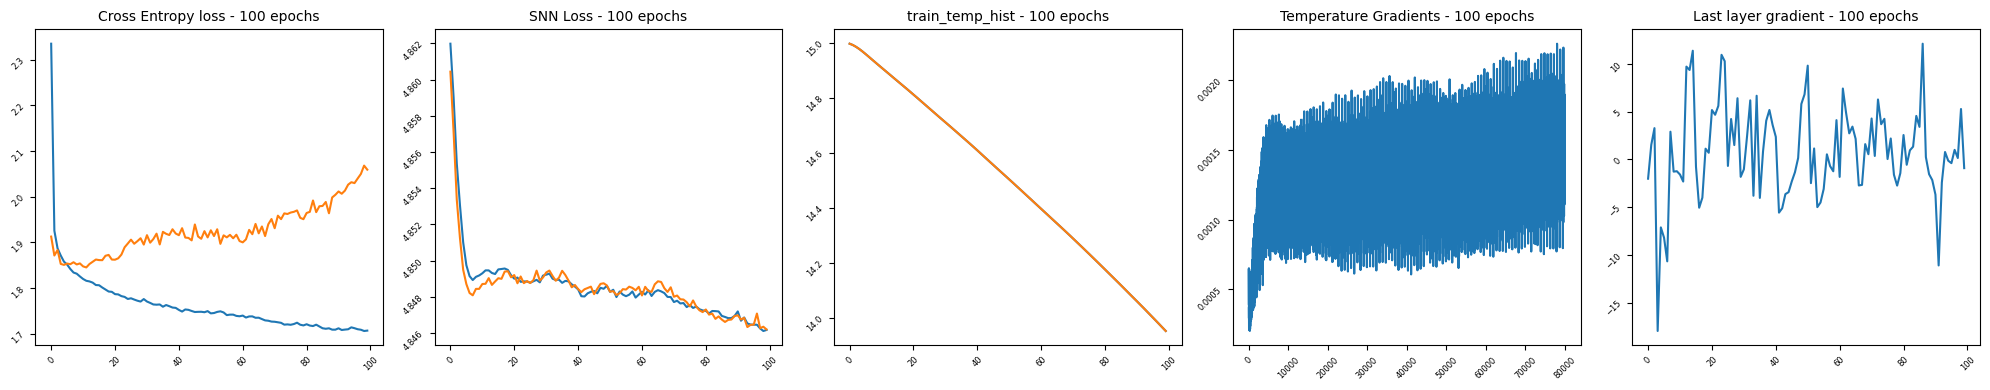

In [54]:
plot_train_history(model, n_bins = 25)

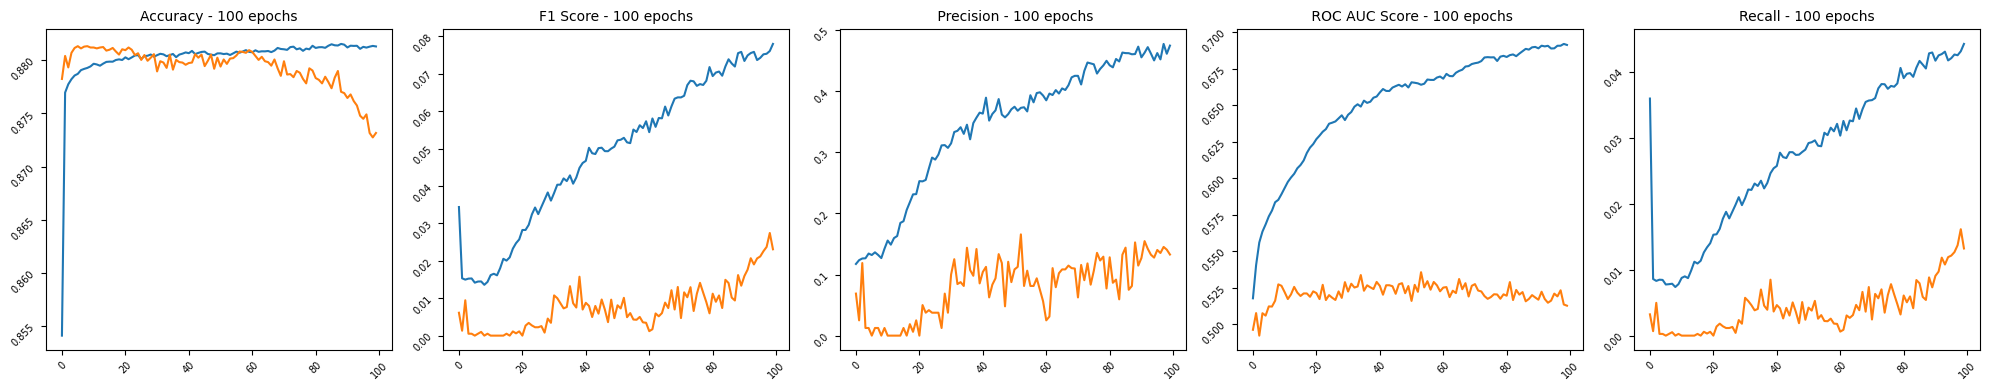

In [55]:
plot_train_metrics(model, n_bins = 25)

       | Weights:                                           |  Biases:                                  |   Gradients:                       |
 layer |                      min         max        stdev  |             min         max        stdev  |      min        max         stdev  |
    0  | (512, 1471)      -1.385925    1.428584    0.090263 |    512  -0.477919    0.565174    0.170684 |  -0.003019    0.002732    0.000199 |
    1  | (128, 512)       -1.961576    1.566233    0.042737 |    128  -2.472799    0.908998    0.488167 |  -0.007796    0.007370    0.000738 |
    2  | (1, 128)         -0.011310    0.015623    0.004380 |      1  -2.125040   -2.125040    0.000000 |  -6.629296    1.212227    0.650139 |


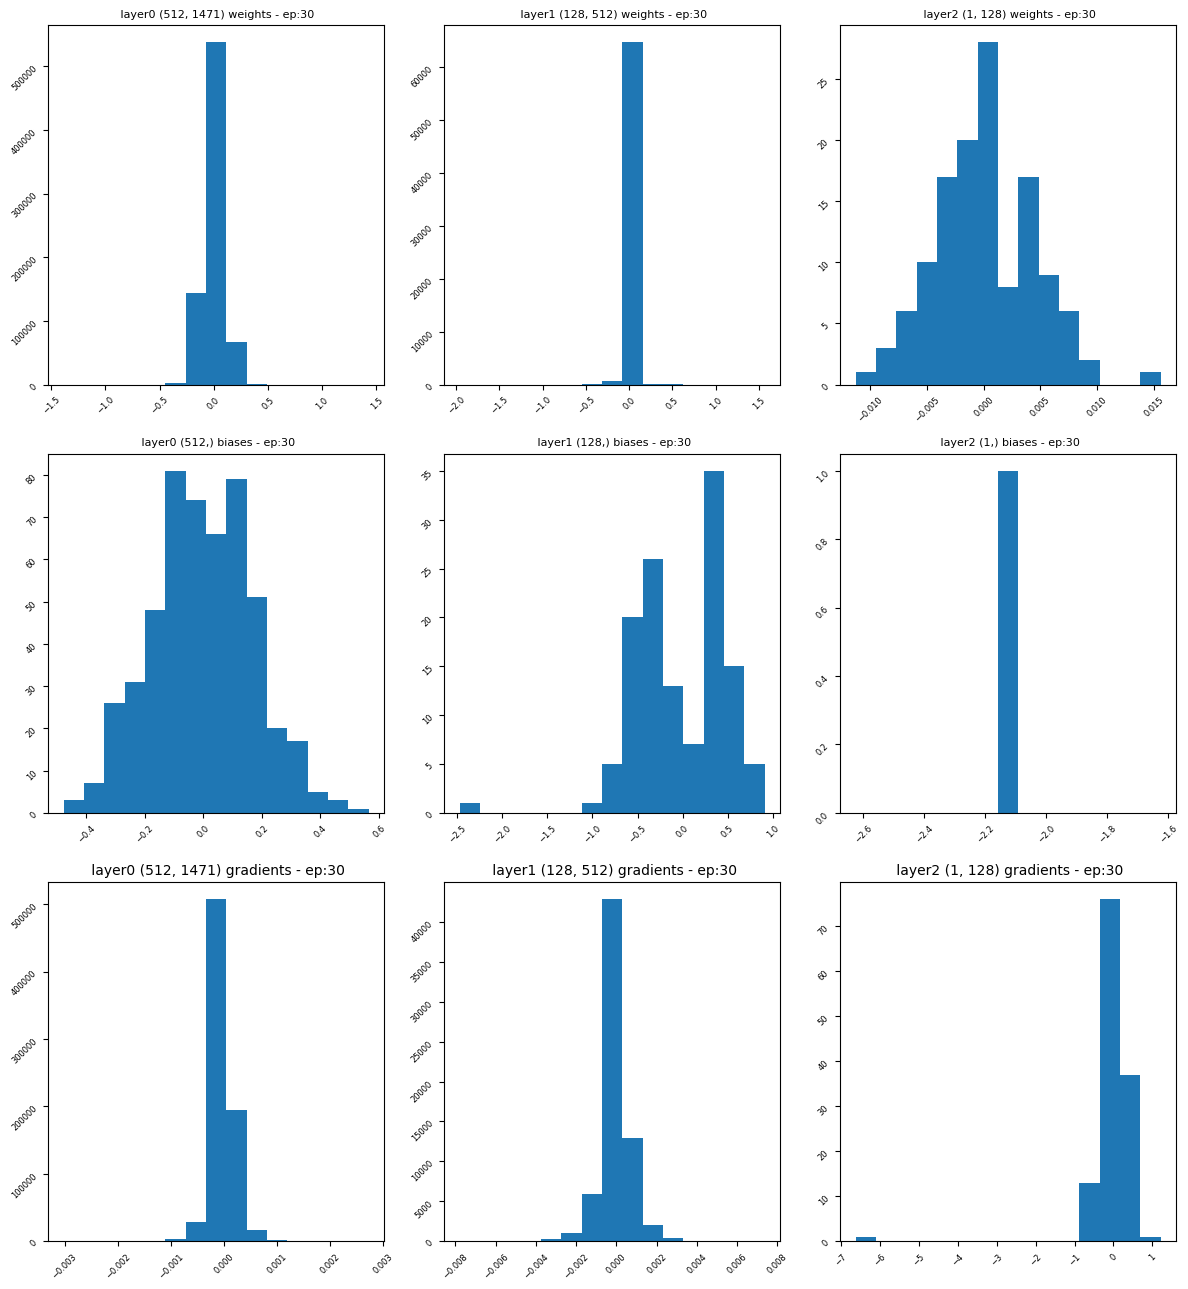

In [44]:
plot_model_parms(model, epochs= epochs, n_bins = 15)

## Other Misc Plots

In [ ]:
for name, parm in model.named_parameters():
    print(f'{name} parameter ---- {parm.data.shape}')
    # print(parm.data)
    print(f' {name} gradient ---- {parm.grad.data.shape}')
    print(parm.grad.data)
    print('\n\n')
    # print(name, parm.weight.shape, parm.grad.shape)

In [ ]:
plt.plot(model.train_temp_grad_hist[:38])
plt.title(f'train_temperature_gradient_hist')
plt.show()
plt.plot(model.train_temp_grad_hist[38:42])
plt.title(f'train_temperature_gradient_hist')
plt.show()
plt.plot(model.train_temp_grad_hist[42:])
plt.title(f'train_temperature_gradient_hist')
plt.show()

In [ ]:
plt.plot(model.temperature_gradients)
plt.show()
plt.plot(model.temperature_gradients[:23600])
plt.show()
plt.plot(model.temperature_gradients[:43600])
plt.show()
plt.plot(model.temperature_gradients[55000:57000])
plt.show()
plt.plot(model.temperature_gradients[250000:])

## Save model results and model

In [48]:
# import datetime.timezone
# datetime.timetz()
epochs_num = epochs
timestamp = datetime.now().strftime('%Y%m%d')
title="dnnconfig03"
filename = f"DNN_{args.model.lower()}_{timestamp}_{title}_{epochs_num:03d}_cpb_{compounds_per_batch}_factor_{int(snnl_factor):d}"
print(f"saved to {filename}")

saved to DNN_snnl_20240430_dnnconfig03_100_cpb_100_factor_1


In [47]:
# save_model(model, filename)
export_results(model=model, filename=filename)
save_checkpoint(epochs, model, filename, update_latest=False, update_best=False)

[INFO] Model Results exported to results/DNN_snnl_20240430_dnnconfig03_030_cpb_100_factor_1.json.
[INFO] Model exported to ckpts/DNN_snnl_20240430_dnnconfig03_030_cpb_100_factor_1.pt.


## SNNL Outputs

In [ ]:
model.snnl_criterion.layers_snnl
# model.snnl_criterion.snnl_loss

In [ ]:
model.snnl_criterion.pairwise_distance_matrix[:9,:9]

In [ ]:
model.snnl_criterion.sampling_probability[:9,:9]

In [ ]:
model.snnl_criterion.masked_pick_probability[:9,:9]
9.4345e-04+  6.9088e-04+  2.6218e-05

In [ ]:
model.snnl_criterion.summed_masked_pick_probability

In [ ]:
torch.mean( -torch.log(model.snnl_criterion.stability_epsilon + model.snnl_criterion.summed_masked_pick_probability))

In [ ]:
# from sklearn.preprocessing import .normalize(
# a = torch.Tensor([[2],[1],[2],[3],[2],[9]]) 
# a.shape 
# # b = torch.Tensor([[3],[4],[2],[4],[5],[5]])
# a = torch.Tensor([2,1,2,3,2,9])
# b = torch.Tensor([3,4,2,4,5,5])
# product = torch.matmul(a, b)
# product
# normalized_a = torch.nn.functional.normalize(a, dim=0, p=2)
# normalized_b = torch.nn.functional.normalize(b, dim=0, p=2)
# normalized_a
# normalized_b
# normalized_b = torch.conj(normalized_b).T
# normalized_b
# product = torch.matmul(normalized_a, normalized_b)
# product
# distance_matrix = torch.sub(torch.tensor(1.0), product)
# distance_matrix

In [ ]:
a = torch.tensor([[0.9041,  0.0196], [-0.3108, -2.4423], [-0.4821,  1.059]])
a.shape
torch.cdist(a, a, p=2)

# Model Inference

## Load model

In [ ]:
fn = "DNN_snnl_withstatictemp_epoch400_2024_04_01_073006.pt"
fn = "DNN_snnl_withlearning_temp_epoch250_2024_04_02_173536_model_epoch_250.pth"
factor=1
epoch = 175
fn = f"DNN_snnl_20240422_temp0grad_{epoch:03d}_cpb_100_factor_{factor:d}.pt"
print(fn)

In [ ]:
# model, last_epoch = load_checkpoint(model, fn)

In [ ]:
model.eval()

model = model.cuda(device=current_device)

In [ ]:
# model_clone = load_model(fn)
# model_clone

In [ ]:
last_epoch


epochs = last_epoch
epoch = last_epoch 
starting_epoch = last_epoch

starting_epoch, epoch , epochs

In [ ]:
# epochs = 40 
# starting_epoch = 20
epochs = epochs + 10
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs}  -- {epoch}")

#### Load model results

In [ ]:
# fn = "DNN_snnl_withstatictemp_epoch400_2024_04_01_073006.pt"
fn = "DNN_snnl_withlearning_temp_epoch250_2024_04_02_173536.json"
fn = f"DNN_snnl_20240422_temp0grad_{epoch:03d}_cpb_100_factor_{factor:d}.json"
print(fn)

In [ ]:
results = import_results(fn)

In [ ]:
results.keys()

In [ ]:
for k in results.keys():
    print(f" key: {k:30s}  length of - loaded results: {len(results[k])}  existing model: {len(model.__dict__[k])}" )
    model.__dict__[k] = results[k]

In [ ]:
# for k in results.keys():
#     print(f" key: {k:30s}  length of - loaded results: {len(results[k])}  existing model: {len(model.__dict__[k])}" )

## Predict

In [ ]:
if dataset == 'cellpainting':
    print(f" load {dataset}")
    test_dataset = CellpaintingDataset(test = True, **cellpainting_args)
    test_loader = InfiniteDataLoader(dataset=test_dataset, batch_size=batch_size, shuffle = False, num_workers = 0, collate_fn = train_dataset.custom_collate_fn)
    

In [ ]:
model.eval()
model = model.cpu()

In [ ]:
for batch_count, (batch_features, batch_labels, _, _, _) in enumerate(train_loader): 
    batch_features = batch_features.to(self.device)
    batch_labels = batch_labels.to(self.device)
    output, predictions = model.predict(test_features)

In [ ]:
for idx, batch in enumerate(val_loader):
    print(idx, batch[0].shape, batch[1].shape,batch[2].shape,batch[3].shape,batch[4].shape)
    # test_features = batch[0].reshape(-1, 784)
    # print(batch[1])
    # display_cellpainting_batch(idx, batch)
    # train_batch_id +=1
    # if train_batch_id ==3 :
        # break
    # if idx >= 24:
        # break
    break

In [ ]:
# test_features = test_dataset.dataa.reshape(-1, 784) / 255.0
test_features = batch[0] 

In [ ]:
for 
output, predictions = model.predict(test_features)
model.test_accuracy = accuracy(y_true=test_dataset.targets, y_pred=predictions)

In [ ]:
print(f"accuracy: {model.test_accuracy}%")

In [ ]:
print(f"accuracy: {model.test_accuracy}%")

In [ ]:
print(f"accuracy: {model.test_accuracy}%")

In [ ]:
filename = f"DNN-{args.model.lower()}-{args.seed}.json"
export_results(model=model, filename=filename)

# `epoch_train(self, data_loader, epoch)` - STEP BY STEP

    def epoch_train(self, data_loader: torch.utils.data.DataLoader, epoch: int = None) -> Tuple:

In [ ]:
model.snnl_criterion = SNNLoss(
        mode=model.mode,
        criterion=model.primary_criterion,
        factor=model.factor,
        temperature=model.temperature,
        use_annealing=model.use_annealing,
        use_sum=model.use_sum,
        # unsupervised=model.unsupervised,
        unsupervised=True,
        code_units=model.code_units,
        sample_size = model.sample_size,
        stability_epsilon=model.stability_epsilon,
)
model.unsupervised

In [ ]:
# if model.use_snnl:
# if model.name == "DNN" or model.name == "CNN":
epoch_loss = 0
epoch_ttl_loss = 0
epoch_primary_loss = 0
epoch_snn_loss = 0
epoch_accuracy = 0

# model.snnl_criterion.factor 
# model.snnl_criterion.factor = 2
# model.snnl_criterion.factor 

### Loop through data

In [ ]:
for batch_count, (batch_features, batch_labels, _, _, _) in enumerate(train_loader):
    if batch_count  == 71:
        break
    # ,_,_,batch_features, batch_labels = next(iter(data_loader))
    # batch_features, batch_labels = next(iter(data_loader))

    # if model.name in ["Autoencoder", "DNN"]:
        # batch_features = batch_features.view(batch_features.shape[0], -1)

In [ ]:
batch_count

In [ ]:
    
batch_features = batch_features.to(model.device)
batch_labels = batch_labels.to(model.device)
    
model.optimizer.zero_grad()
    
outputs = model.forward(features=batch_features)
    # break

In [ ]:
# outputs

In [ ]:
    if model.use_snnl:
        train_loss, primary_loss, snn_loss = model.snnl_criterion(
            model=model,
            outputs=outputs,
            features=batch_features,
            labels=batch_labels,
            epoch=epoch,
        )
        epoch_loss += train_loss.item()
        epoch_snn_loss += snn_loss.item()
        epoch_primary_loss += primary_loss.item()
    else:
        # if not model.use_snnl:
        print(f"Model not using SNNL")
        train_loss = model.criterion(outputs, batch_labels if model.name == "DNN" or model.name == "CNN"  else batch_features,)
        epoch_loss += train_loss.item()

In [ ]:
 
    if model.name == "DNN" or model.name == "CNN":
        train_accuracy = (outputs.argmax(1) == batch_labels).sum().item() / len(batch_labels)
        epoch_accuracy += train_accuracy
    else:
        train_accuracy =  0
        epoch_accuracy += train_accuracy
    
    train_loss.backward()
    model.optimizer.step()
    
    if model.use_snnl and model.temperature is not None:
        model.optimize_temperature()
    
    # print(outputs.shape)
    # print(batch_labels.shape)
    print(f" batch:{batch_count} - train : loss    {train_loss:10.6f}   primary loss: {primary_loss:10.6f}    SNN loss: {snn_loss*model.snnl_criterion.factor:10.6f}   (loss: {snn_loss:10.6f} * factor: {model.snnl_criterion.factor})  "
          f"  temp: {model.temperature.data} snnl_temp: {model.snnl_criterion.temperature.data}")    
    # print(f" epoch : loss    {epoch_loss:10.6f}   primary_loss: {epoch_primary_loss:10.6f}    SNN loss: {epoch_snn_loss:10.6f}   factor: {model.factor}")
    # print(f" batch_accuracy         {train_accuracy}   epoch_accuracy         {epoch_accuracy}")
    break
#### End of dataloader loop

In [ ]:
print(f" loop ended - batch_count: {batch_count}")

In [ ]:
primary_loss
primary_loss.shape, primary_loss.size(), primary_loss.data, primary_loss.ndim

In [ ]:
pp = torch.zeros(0,requires_grad = True, dtype=torch.float32)
p1 = torch.tensor(0,requires_grad = True, dtype=torch.float32, device = model.device)
pp.shape, pp.size(), pp.data, pp.ndim
p1.shape, p1.size(), p1.data, p1.ndim

In [ ]:
len_data_loader = batch_count

In [ ]:
len_data_loader
epoch_loss, epoch_loss/len_data_loader
epoch_snn_loss * model.snnl_criterion.factor, (epoch_snn_loss * model.snnl_criterion.factor)/len_data_loader, epoch_snn_loss
epoch_primary_loss, epoch_primary_loss/len_data_loader
epoch_accuracy / len_data_loader

# SNNL Loss

In [ ]:
# input1 = torch.randn(100, 128)
# input2 = torch.randn(100, 128)
# cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
# tmp1 = cos(input1, input2)
# tmp1.shape
# # tmp1

# value.shape

# tmp1 = torch.cdist(value, value, p=2)
# cosim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
# tmp1 = cosim(value, value.T)
# tmp1.shape
# tmp1
# tmp1.min(), tmp1.argmin()

In [ ]:
batch_count  = 0
iter_loader = iter(train_loader)

In [ ]:
(batch_features, batch_labels, _, _, _) = next(iter_loader)

In [ ]:
    
batch_features = batch_features.to(model.device)
batch_labels = batch_labels.to(model.device)
    
model.optimizer.zero_grad()
    
outputs = model.forward(features=batch_features)
    # break

In [ ]:
def pairwise_cosine_distance(features: torch.Tensor) -> torch.Tensor:
    """
    Returns the pairwise cosine distance between two copies
    of the features matrix.

    Parameter
    ---------
    features: torch.Tensor
        The input features.

    Returns
    -------
    distance_matrix: torch.Tensor
        The pairwise cosine distance matrix.

    Example
    -------
    >>> import torch
    >>> from snnl import SNNLoss
    >>> _ = torch.manual_seed(42)
    >>> a = torch.rand((4, 2))
    >>> snnl = SNNLoss(temperature=1.0)
    >>> snnl.pairwise_cosine_distance(a)
    tensor([[1.1921e-07, 7.4125e-02, 1.8179e-02, 1.0152e-01],
            [7.4125e-02, 1.1921e-07, 1.9241e-02, 2.2473e-03],
            [1.8179e-02, 1.9241e-02, 1.1921e-07, 3.4526e-02],
            [1.0152e-01, 2.2473e-03, 3.4526e-02, 0.0000e+00]])
    """
    a, b = features.clone(), features.clone()
    normalized_a = torch.nn.functional.normalize(a, dim=1, p=2)
    normalized_b = torch.nn.functional.normalize(b, dim=1, p=2)
    # normalized_b = torch.conj(normalized_b).T
    product = torch.matmul(normalized_a, normalized_b.T)
    distance_matrix = torch.sub(torch.tensor(1.0), product)
    return distance_matrix

def normalize_distance_matrix(
    self,
    features: torch.Tensor,
    distance_matrix: torch.Tensor,
    device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
) -> torch.Tensor:

    pairwise_distance_matrix = torch.exp( -(distance_matrix * self.temperature)) - torch.eye(features.shape[0]).to(device)
    
    return pairwise_distance_matrix

def pairwise_cos_distance(A, B):
    
    """Pairwise cosine distance between two matrices.
    :param A: a matrix.
    :param B: a matrix.
    :returns: A tensor for the pairwise cosine between A and B.
    """
    normalized_A = torch.nn.functional.normalize(A, dim=1)
    normalized_B = torch.nn.functional.normalize(B, dim=1)
    prod = torch.matmul(normalized_A, normalized_B.transpose(-2, -1).conj())
    return 1 - prod

In [ ]:
print('\n'+'-'*80)
print('1 - pairwise_cos_distance')
print('-'*80)
tmp1 =  pairwise_cosine_distance(value)
tmp1.shape
tmp1
tmp1.sum()
tmp1.min(), tmp1.argmin()

print('\n'+'-'*80)
print('2 - torch.exp(-(distance_matrix / temp))')
print('-'*80)
tmp2 = torch.exp(-(tmp1 / snnl.temperature)) 
tmp2.shape
tmp2
tmp2.sum()
tmp2.min(), tmp2.argmin()


print('\n'+'-'*80)
print('3 - pairwise_distance_matrix')
print('-'*80)
tmp3 = torch.exp(-(tmp1 / snnl.temperature)) - torch.eye(batch_features.shape[0]).to(model.device) 
tmp3.shape
tmp3
tmp3.sum()
tmp3.min(), tmp3.argmin()

### V1 Code

In [ ]:
from dev_code import SNNLoss

In [ ]:
model.temperature
snnl.temperature

In [ ]:
snnl =SNNLoss(
                mode=model.mode,
                criterion=model.primary_criterion,
                factor=model.factor,
                temperature=model.temperature,
                use_annealing=model.use_annealing,
                use_sum=model.use_sum,
                code_units=model.code_units,
                sample_size = model.sample_size,
                stability_epsilon=model.stability_epsilon,
                unsupervised=model.unsupervised,
            )

In [ ]:
snnl.temperature

In [ ]:
# snnl.temperature = 8.762743
train_loss,primary_loss,snnl_loss = train_loss, primary_loss, snn_loss = snnl(
                    model=model,
                    outputs=outputs,
                    features=batch_features,
                    labels=batch_labels,
                    epoch=1,
                )
train_loss,primary_loss,snnl_loss

In [ ]:
snnl.layers_snnl

In [ ]:
activations = snnl.compute_activations(model=model, features=batch_features)

In [ ]:
for k,v in activations.items():
    print(k, v.shape, v.sum().item())


In [ ]:
def snnlV1_fixed_debug( inp_values = None, inp_labels = None):
    print('-'*80)
    print('1 - pairwise_cos_distance')
    print('-'*80)
    snnl.distance_matrix = snnl.pairwise_cosine_distance(features = inp_values)
    print(snnl.distance_matrix.shape)
    # print(snnl.distance_matrix)
    print(snnl.distance_matrix.sum())
    print(snnl.distance_matrix.min(), snnl.distance_matrix.argmin())
    
    print('-'*80)
    print('2 - torch.exp(-(distance_matrix / temp))')
    print('-'*80)
    tmp2 = torch.exp(-(snnl.distance_matrix / snnl.temperature)) 
    print(tmp2.shape)
    # print(tmp2)
    print(tmp2.sum())
    print(tmp2.min(), tmp2.argmin())
    
    print('-'*80)
    print('2 - pairwise_distance_matrix')
    print('-'*80)
    snnl.pairwise_distance_matrix = snnl.normalize_distance_matrix(features = inp_values, distance_matrix = snnl.distance_matrix, device = 'cuda:0')
    print(snnl.pairwise_distance_matrix.shape   )
    # print(snnl.pairwise_distance_matrix)
    print(snnl.pairwise_distance_matrix.sum())
    print(snnl.pairwise_distance_matrix.min(), snnl.pairwise_distance_matrix.argmin()   )
    
    print('-'*80)
    print('3 - pick probability')
    print('-'*80)
    snnl.pick_probability = snnl.compute_sampling_probability(snnl.pairwise_distance_matrix)
    snnl.pick_probability = torch.clamp(snnl.pick_probability,0,None)
    print(snnl.pick_probability.shape)
    # print(snnl.pick_probability)
    print(snnl.pick_probability.sum())
    print(snnl.pick_probability.min(), snnl.pick_probability.argmin()   )

    snnl.summed_masked_pick_probability = snnl.mask_sampling_probability(labels = inp_labels, sampling_probability = snnl.pick_probability, device = 'cuda:0')
    
    print('-'*80)
    print('4 - masked pick probability')
    print('-'*80)
    print(snnl.masked_pick_probability.shape)
    # print(snnl.masked_pick_probability)
    print(snnl.masked_pick_probability.sum())
    print(snnl.masked_pick_probability.min(), snnl.masked_pick_probability.argmin())
        
    print('-'*80)
    print('5 - summed masked pick probability')
    print('-'*80)
    # snnl.summed_masked_pick_probability = snnl.mask_sampling_probability(labels = inp_labels, sampling_probability = snnl.pick_probability, device = 'cuda:0')
    print(snnl.summed_masked_pick_probability.shape)
    # print(snnl.summed_masked_pick_probability)
    print(snnl.summed_masked_pick_probability.sum(0))
    print(snnl.summed_masked_pick_probability.min(), snnl.summed_masked_pick_probability.argmin())
    
    print('-'*80)
    print('6 - Log summed masked pick probability')
    print('-'*80)
    snnl_loss = torch.mean( -torch.log(snnl.stability_epsilon + snnl.summed_masked_pick_probability))
    print(snnl_loss)

In [ ]:
def snnlV1_debug( inp_values = None, inp_labels = None, verbose = False):
    print('-'*80)
    print('1 - pairwise_cos_distance')
    print('-'*80)
    snnl.distance_matrix = snnl.pairwise_cosine_distance(features = inp_values)
    print(snnl.distance_matrix.shape)
    if verbose:
        print(snnl.distance_matrix)
    print(snnl.distance_matrix.sum())
    print(snnl.distance_matrix.min(), snnl.distance_matrix.argmin())
    
    print('-'*80)
    print('2 - torch.exp(-(distance_matrix / temp))')
    print('-'*80)
    tmp2 = torch.exp(-(snnl.distance_matrix / snnl.temperature)) 
    print(tmp2.shape)
    if verbose:
        print(tmp2)
    print(tmp2.sum())
    print(tmp2.min(), tmp2.argmin())
    
    
    print('-'*80)
    print('2 - pairwise_distance_matrix')
    print('-'*80)
    snnl.pairwise_distance_matrix = snnl.normalize_distance_matrix(features = inp_values, distance_matrix = snnl.distance_matrix, device = 'cuda:0')
    print(snnl.pairwise_distance_matrix.shape   )
    if verbose:
        print(snnl.pairwise_distance_matrix)
    print(snnl.pairwise_distance_matrix.sum())
    print(snnl.pairwise_distance_matrix.min(), snnl.pairwise_distance_matrix.argmin()   )
    
    print('-'*80)
    print('3.A - pick probability unclamped')
    print('-'*80)
    tmp3 = snnl.pairwise_distance_matrix / (snnl.stability_epsilon + snnl.pairwise_distance_matrix.sum(1).unsqueeze(1))
    print(tmp3.shape)
    if verbose:
        print(tmp3)
    print(tmp3.sum())
    print(tmp3.min(), tmp3.argmin()   )

    print('-'*80)
    print('3 - pick probability')
    print('-'*80)
    snnl.pick_probability = snnl.compute_sampling_probability(snnl.pairwise_distance_matrix)
    print(snnl.pick_probability.shape)
    if verbose:
        print(snnl.pick_probability)
    print(snnl.pick_probability.sum())
    print(snnl.pick_probability.min(), snnl.pick_probability.argmin()   )
    
    snnl.summed_masked_pick_probability = snnl.mask_sampling_probability(labels = inp_labels, sampling_probability = snnl.pick_probability, device = 'cuda:0')
    
    print('-'*80)
    print('4 - masked pick probability')
    print('-'*80)
    print(snnl.masked_pick_probability.shape)
    if verbose:
        print(snnl.masked_pick_probability)
    print(snnl.masked_pick_probability.sum())
    print(snnl.masked_pick_probability.min(), snnl.masked_pick_probability.argmin())
        
    print('-'*80)
    print('5 - summed masked pick probability')
    print('-'*80)
    # snnl.summed_masked_pick_probability = snnl.mask_sampling_probability(labels = inp_labels, sampling_probability = snnl.pick_probability, device = 'cuda:0')
    print(snnl.summed_masked_pick_probability.shape)
    if verbose:
        print(snnl.summed_masked_pick_probability)
    print(snnl.summed_masked_pick_probability.sum(0))
    print(snnl.summed_masked_pick_probability.min(), snnl.summed_masked_pick_probability.argmin())
    
    print('-'*80)
    print('6 - Log summed masked pick probability')
    print('-'*80)
    snnl_loss = torch.mean( -torch.log(snnl.stability_epsilon + snnl.summed_masked_pick_probability))
    print(snnl_loss)

### V2 Code

In [ ]:
from snnl.losses import SNNLCrossEntropy

In [ ]:
snnlV2device ='cuda:0'
snnlV2device ='cpu'
snnlV2 = SNNLCrossEntropy(model,
                         temperature=snnl.temperature.to('cpu'),
                         layer_names=[0,1,2,3,4],
                         factor=-10.,
                         optimize_temperature=True,
                         cos_distance=True)

snnlV2

In [ ]:
snnl.temperature
snnlV2.temperature

In [ ]:
temp = snnl.temperature.to(snnlV2device)
temp
sample_labels = snnl.sample_labels.to(snnlV2device) 
# sample_labels

In [ ]:
for k,v in activations.items():
    tmp1 = snnlV2.SNNL(x = v.to(snnlV2device) ,  y = snnl.sample_labels.to(snnlV2device), temp = temp.to(snnlV2device) ) 
    print(f"layer {k}  snnlV2 loss: {tmp1}")
# torch.arange(batch_labels.shape[0]).to('cuda:0') // snnl.sample_size

In [ ]:
def snnlV2_fixed_debug( inp_values = None, inp_labels = None , temp = temp):
    print('-'*80)
    print('1 - pairwise_cos_distance')
    print('-'*80)
    tmp1 = snnlV2.pairwise_cos_distance(inp_values, inp_values)
    print(tmp1.shape)
    # print(tmp1)
    print(tmp1.sum())
    print(tmp1.min(), tmp1.argmin())
    
    print('-'*80)
    print('2 - torch.exp(-(distance_matrix / temp))')
    print('-'*80)
    tmp2 = torch.exp(-(tmp1 / temp))
    print(tmp2.shape)
    # print(tmp2)
    print(tmp2.sum())
    print(tmp2.min(), tmp2.argmin())
    
    print('-'*80)
    print('3 - torch.exp(-(distance_matrix / temp)) - torch.eye(value.shape[0] ')
    print('-'*80)
    tmp3 = tmp2 - torch.eye(inp_values.shape[0]) 
    print(tmp3.shape)
    # print(tmp3)
    print(tmp3.sum())
    print(tmp3.min(), tmp3.argmin())
    
    print('-'*80)
    print('4 - PickProbability --- tmp4 / (SNNLCrossEntropy.STABILITY_EPS + tmp4.sum(axis=1).unsqueeze(1))')
    print('-'*80) 
    tmp4 = tmp3 / (SNNLCrossEntropy.STABILITY_EPS + tmp3.sum(axis=1).unsqueeze(1))
    tmp4 = torch.clamp(tmp4,0,None)
    print(tmp4.shape)
    # print(tmp4)
    print(tmp4.sum())
    print(tmp4.min(), tmp4.argmin())
    
    print('-'*80)
    print('5 - MaskedPickProbability ')
    print('-'*80) 
    tmp5 = tmp4.to('cpu') * snnlV2.same_label_mask(inp_labels, inp_labels )
    print(tmp5.shape)
    # print(tmp5)
    print(tmp5.sum())
    print(tmp5.min(), tmp5.argmin())
    
    print('-'*80)
    print('6 -  SummedMaskedPickProbability ')
    print('-'*80) 
    tmp6 = tmp5.sum(axis=1)    
    print(tmp6.shape)
    # print(tmp6)
    print(tmp6.sum(0))
    print(tmp6.min(), tmp6.argmin())
    
    print('-'*80)
    print('7 - SummedMaskedPickProbability ')
    print('-'*80) 
    tmp7 =  -torch.log(SNNLCrossEntropy.STABILITY_EPS + tmp6).mean()
    print(tmp7.shape)
    print(tmp7)
    
    # summed_masked_pick_prob = SNNLCrossEntropy.masked_pick_probability(x, y, temp, cos_distance).sum(axis=1)
    # snnlV2.same_label_mask(sample_labels, sample_labels)

In [ ]:
def snnlV2_debug( inp_values = None, inp_labels = None , temp = temp):
    print('-'*80)
    print('1 - pairwise_cos_distance')
    print('-'*80)
    tmp1 = snnlV2.pairwise_cos_distance(inp_values, inp_values)
    print(tmp1.shape)
    # print(tmp1)
    print(tmp1.sum())
    print(tmp1.min(), tmp1.argmin())
    
    print('-'*80)
    print('2 - torch.exp(-(distance_matrix / temp))')
    print('-'*80)
    tmp2 = torch.exp(-(tmp1 / temp))
    print(tmp2.shape)
    # print(tmp2)
    print(tmp2.sum())
    print(tmp2.min(), tmp2.argmin())
    
    print('-'*80)
    print('3 - torch.exp(-(distance_matrix / temp)) - torch.eye(value.shape[0] ')
    print('-'*80)
    tmp3 = tmp2 - torch.eye(inp_values.shape[0]) 
    print(tmp3.shape)
    # print(tmp3)
    print(tmp3.sum())
    print(tmp3.min(), tmp3.argmin())
    
    print('-'*80)
    print('4 - PickProbability --- tmp4 / (SNNLCrossEntropy.STABILITY_EPS + tmp4.sum(axis=1).unsqueeze(1))')
    print('-'*80) 
    tmp4 = tmp3 / (SNNLCrossEntropy.STABILITY_EPS + tmp3.sum(axis=1).unsqueeze(1))
    print(tmp4.shape)
    # print(tmp4)
    print(tmp4.sum())
    print(tmp4.min(), tmp4.argmin())
    
    print('-'*80)
    print('5 - MaskedPickProbability ')
    print('-'*80) 
    tmp5 = tmp4.to('cpu') * snnlV2.same_label_mask(inp_labels, inp_labels )
    print(tmp5.shape)
    # print(tmp5)
    print(tmp5.sum())
    print(tmp5.min(), tmp5.argmin())
    
    print('-'*80)
    print('6 -  SummedMaskedPickProbability ')
    print('-'*80) 
    tmp6 = tmp5.sum(axis=1)
    print(tmp6.shape)
    # print(tmp6)
    print(tmp6.sum(0))
    print(tmp6.min(), tmp6.argmin())
    
    
    print('-'*80)
    print('7 - SummedMaskedPickProbability ')
    print('-'*80) 
    tmp7 =  -torch.log(SNNLCrossEntropy.STABILITY_EPS + tmp6).mean()
    print(tmp7.shape)
    print(tmp7)
    
    # summed_masked_pick_prob = SNNLCrossEntropy.masked_pick_probability(x, y, temp, cos_distance).sum(axis=1)
    # snnlV2.same_label_mask(sample_labels, sample_labels)

### Debug

In [ ]:
layer_id = 0

In [ ]:
snnlV1_debug(inp_values = activations[layer_id], inp_labels = batch_labels, verbose = True)

In [ ]:
snnlV1_fixed_debug(inp_values = activations[layer_id], inp_labels = batch_labels)

In [ ]:
snnlV2_debug( inp_values = activations[layer_id].to('cpu'), inp_labels = sample_labels.to('cpu'), temp = temp)

In [ ]:
snnlV2_fixed_debug( inp_values = activations[layer_id].to('cpu'), inp_labels = sample_labels.to('cpu'), temp = temp)

In [ ]:
print('\n'+'-'*80)
print('1 - pairwise_cos_distance')
print('-'*80)
tmp1 = snnlV2.pairwise_cos_distance(value, value)
# tmp1 = torch.clamp(tmp1,0,None)
tmp1.shape
tmp1
tmp1.sum()
tmp1.min(), tmp1.argmin()

print('\n'+'-'*80)
print('2 - torch.exp(-(distance_matrix / temp))')
print('-'*80)
tmp2 = torch.exp(-(tmp1 / temp))
# tmp2 = torch.clamp(tmp2,0,None)
tmp2.shape
tmp2
tmp2.sum()
tmp2.min(), tmp2.argmin()

print('\n'+'-'*80)
print('3 - torch.exp(-(distance_matrix / temp)) - torch.eye(value.shape[0] ')
print('-'*80)
tmp3 = tmp2 - torch.eye(value.shape[0]).to('cuda')
tmp3 = torch.clamp(tmp3,0,None)
tmp3.shape
tmp3
tmp3.sum()
tmp3.min(), tmp3.argmin()

print('\n'+'-'*80)
print('4 - PickProbability --- tmp4 / (SNNLCrossEntropy.STABILITY_EPS + tmp4.sum(axis=1).unsqueeze(1))')
print('-'*80) 
tmp4 = tmp3 / (SNNLCrossEntropy.STABILITY_EPS + tmp3.sum(axis=1).unsqueeze(1))
tmp4.shape
# tmp4[:10,:10]
tmp4
tmp4.sum()
tmp4.min(), tmp4.argmin()

print('\n'+'-'*80)
print('5 - MaskedPickProbability ')
print('-'*80) 
tmp5 = tmp4.to('cpu') * snnlV2.same_label_mask(sample_labels, sample_labels )
tmp5.shape
tmp5
tmp5.sum()
tmp5.min(), tmp5.argmin()

print('\n'+'-'*80)
print('6 -  SummedMaskedPickProbability ')
print('-'*80) 
tmp6 = tmp5.sum(axis=1)
tmp6.shape
tmp6
tmp6.sum(0)
tmp6.min(), tmp6.argmin()


print('\n'+'-'*80)
print('7 - SummedMaskedPickProbability ')
print('-'*80) 
tmp7 =  -torch.log(SNNLCrossEntropy.STABILITY_EPS + tmp6).mean()
tmp7.shape
tmp7

# summed_masked_pick_prob = SNNLCrossEntropy.masked_pick_probability(x, y, temp, cos_distance).sum(axis=1)
# snnlV2.same_label_mask(sample_labels, sample_labels)

 #### Print values used in snnl loss

In [ ]:
# outputs.shape
# outputs[0].data
# outputs.argmax(1)
batch_labels

# batch_labels[1]
# train_accuracy

In [ ]:
# torch.set_printoptions(linewidth=180)

# model.snnl_criterion.distance_matrix[:10,:10]

# model.snnl_criterion.distance_matrix[:10,:10]

# model.snnl_criterion.pairwise_distance_matrix[:10,:10]

# model.snnl_criterion.pick_probability[:10,:10]

# model.snnl_criterion.masking_matrix[:10,:10]

# model.snnl_criterion.masked_pick_probability[:10,:10]

# model.snnl_criterion.summed_masked_pick_probability[:10]

# tmp1 = torch.eq(model.snnl_criterion.sample_labels, model.snnl_criterion.sample_labels.unsqueeze(1)).float()
# tmp1.shape
# tmp1[:12,:12]

In [ ]:
# (outputs.argmax(1) == batch_labels).sum().item()
# len(batch_labels)
# len(data_loader)

# activations = dict()
# layers = model.layers
# for index, layer in enumerate(layers):
#     if index == 0:
#         activations[index] = layer(batch_features)
#     else:
#         activations[index] = layer(activations[index - 1])
# for i in activations:
#     print(activations[i].shape)

In [ ]:
# len_data_loader = batch_count -1
epoch_loss /= len_data_loader

if model.name in ["DNN", "CNN"]:
    epoch_accuracy /= len_data_loader ## len(data_loader)

if model.use_snnl:
    epoch_snn_loss = epoch_snn_loss * model.snnl_criterion.factor / len_data_loader ## len(data_loader)
    epoch_primary_loss /=  len_data_loader  ##  len(data_loader)
    
    if model.name == "DNN" or model.name == "CNN":
        print(f" epoch_loss: {epoch_loss},  epoch_snn_loss: {epoch_snn_loss}, epoch_primaey_loss: {epoch_primary_loss}, accuracy: {epoch_accuracy} ")
        a,b = (epoch_loss, epoch_snn_loss, epoch_primary_loss), epoch_accuracy
    else:
        print(f" epoch_loss: {epoch_loss},  epoch_snn_loss: {epoch_snn_loss}, epoch_primary_loss: {epoch_primary_loss} ")
        a =  (epoch_loss, epoch_snn_loss, epoch_primary_loss)
else:
    if model.name == "DNN" or model.name == "CNN":
        print(f" epoch_loss: {epoch_loss}, accuracy: {epoch_accuracy} ")
        a , b = epoch_loss, epoch_accuracy
    else:
        print(f" epoch_loss: {epoch_loss},")
        a =  epoch_loss